In [1]:
import sys
sys.path.append('../')

In [2]:
import json
from zipfile import ZipFile
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from collections import Counter
import requests as requests

from sklearn.neighbors import KernelDensity

from nltk.tokenize import TweetTokenizer

from data_loading import ChatHighlightData
import utils

## Video info from zipped download

In [80]:
vid_info = list()

info_files_path = "../data/video_info/*_vids.json"
info_files = glob.glob(info_files_path)

for f_name in info_files:
    with open(f_name, "r") as info_file:
        vid_info.extend(json.load(info_file))

# for lookup later
vid2ind = {v["id"]:i for i, v in enumerate(vid_info)}

In [81]:
vid_info[vid2ind["83571434"]]

{'id': '83571434',
 'stream_id': '22827014832',
 'user_id': '30707866',
 'user_login': 'esl_lol',
 'user_name': 'ESL_LOL',
 'title': 'RERUN: fnatic vs. Millenium - Group A - IEM Katowice 2014 - League of Legends',
 'description': '',
 'created_at': '2016-08-14T14:26:23Z',
 'published_at': '2016-08-14T14:26:23Z',
 'url': 'https://www.twitch.tv/videos/83571434',
 'thumbnail_url': 'https://static-cdn.jtvnw.net/cf_vods/d2nvs31859zcd8/ad3ef727c7_esl_lol_22827014832_500493871/thumb/thumb0-%{width}x%{height}.jpg',
 'viewable': 'public',
 'view_count': 36,
 'language': 'en',
 'type': 'archive',
 'duration': '18h30m39s',
 'muted_segments': None}

In [82]:
chat_files_path = "../data/videos_chat/*_vids_chat.zip"
chat_files = glob.glob(chat_files_path)


for chat_file_name in chat_files:
    zf = ZipFile(chat_file_name)
    for f_name in zf.namelist():
        # print(f_name)if f_name.endswith("json") else None
        if f_name.endswith("json"):
            with zf.open(f_name, "r") as in_file:
                vid_chat = json.load(in_file)
                v_ind = vid2ind[f_name.split("/")[-1].strip(".json")]
                chat_info = {
                    "msg_count": len(vid_chat["comments"]),
                    "is_rerun": vid_info[v_ind]["title"].startswith("RERUN") or vid_info[v_ind]["title"].startswith("REBROADCAST") # might want to add more filters in future
                }

                vid_info[v_ind].update(chat_info)

In [83]:
vid_info_filtered = [vinf for vinf in vid_info if "msg_count" in vinf.keys()]

## Video meta data

In [113]:
df_vid_meta = pd.DataFrame.from_records(vid_info)

In [114]:
df_vid_meta["id"] = df_vid_meta["id"].astype(int)

In [115]:
df_vid_meta = df_vid_meta.set_index("id")

In [116]:
df_vid_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5954 entries, 1197898683 to 68667053
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   stream_id       5954 non-null   object 
 1   user_id         5954 non-null   object 
 2   user_login      5954 non-null   object 
 3   user_name       5954 non-null   object 
 4   title           5954 non-null   object 
 5   description     5954 non-null   object 
 6   created_at      5954 non-null   object 
 7   published_at    5954 non-null   object 
 8   url             5954 non-null   object 
 9   thumbnail_url   5954 non-null   object 
 10  viewable        5954 non-null   object 
 11  view_count      5954 non-null   int64  
 12  language        5954 non-null   object 
 13  type            5954 non-null   object 
 14  duration        5954 non-null   object 
 15  muted_segments  0 non-null      object 
 16  msg_count       1366 non-null   float64
 17  is_rerun        1366

In [123]:
df_vid_meta = df_vid_meta.sort_index()
df_vid_meta

,stream_id,user_id,user_login,user_name,title,description,created_at,published_at,url,thumbnail_url,viewable,view_count,language,type,duration,muted_segments,msg_count,is_rerun
id,,,,,,,,,,,,,,,,,,
3590598,12100270576,29823133,garenaesports,GarenaEsports,TLC Winter 2014 W5D2 IFF vs TCC,,2014-12-07T05:58:17Z,2014-12-07T05:58:16.874383Z,https://www.twitch.tv/videos/3590598,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,7,en,archive,5h0m17s,None,0.0,False
3597104,12137404288,29823133,garenaesports,GarenaEsports,GPL 2015 W1 D1,,2014-12-10T09:35:01Z,2014-12-10T09:35:01.068176Z,https://www.twitch.tv/videos/3597104,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,82,en,archive,4h31m27s,None,0.0,False
3599435,12148443600,29823133,garenaesports,GarenaEsports,GPL Spring 2015 W1D2,,2014-12-11T09:26:38Z,2014-12-11T09:26:38.105768Z,https://www.twitch.tv/videos/3599435,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,53,en,archive,4h32m7s,None,0.0,False
3601673,12159852080,29823133,garenaesports,GarenaEsports,GPL Spring 2015 W1D3,,2014-12-12T09:34:23Z,2014-12-12T09:34:23.221294Z,https://www.twitch.tv/videos/3601673,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,29,en,archive,4h20m49s,None,0.0,False
3615234,12223198800,29823133,garenaesports,GarenaEsports,GPL Spring 2015 W2D1,,2014-12-17T09:43:50Z,2014-12-17T09:43:50.123506Z,https://www.twitch.tv/videos/3615234,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,30,en,archive,4h14m10s,None,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417245159,44890397004,124422593,lec,LEC,Week 8 Day 3 - 2022 Spring LEC,,2022-03-06T14:20:51Z,2022-03-06T14:20:51Z,https://www.twitch.tv/videos/1417245159,https://static-cdn.jtvnw.net/cf_vods/dgeft87wb...,public,1249771,en,archive,6h48m58s,None,NaN,NaN
1417645450,44894508972,36029255,riotgames,Riot Games,IMT vs TL - Week 5 Day 2 | LCS Spring Split (2...,,2022-03-06T21:10:14Z,2022-03-06T21:10:14Z,https://www.twitch.tv/videos/1417645450,https://static-cdn.jtvnw.net/cf_vods/dgeft87wb...,public,28675,en,archive,4h19m7s,None,NaN,NaN
1417946885,45763031901,124422593,lec,LEC,(Rebroadcast) Week 8 Day 3 - 2022 Spring LEC,,2022-03-07T01:57:31Z,2022-03-07T01:57:31Z,https://www.twitch.tv/videos/1417946885,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,66302,en,archive,5h47m55s,None,NaN,NaN


## Video info into dataframe

In [155]:
"""
cols = ["id", "title", "created_at", "msg_count", "is_rerun", "duration"]

df_vid_info = pd.DataFrame(vid_info_filtered, columns=cols)
df_vid_info["created_at"] = pd.to_datetime(df_vid_info["created_at"])
"""
df_vid_info = pd.read_csv("../data/video_info/vid_info.csv")
df_vid_info = df_vid_info.drop("Unnamed: 0", axis=1)
df_vid_info = df_vid_info.set_index("id")
#df_vid_info

In [156]:
df_msg_info = pd.read_csv("../data/video_info/msg_info.csv")
df_msg_info = df_msg_info.set_index("Unnamed: 0")
df_msg_info.index.name = "id"
df_msg_info["num_tokens"] = df_msg_info.apply(lambda x: 0 if x["num_chars"]==0 else x["num_tokens"] ,axis=1)
df_msg_info["longest_message_toks"] = df_msg_info.apply(lambda x: 0 if x["num_chars"]==0 else x["longest_message_toks"] ,axis=1)
df_msg_info["shortest_message_toks"] = df_msg_info.apply(lambda x: 0 if x["num_chars"]==0 else x["shortest_message_toks"] ,axis=1)
#df_msg_info

In [157]:
df_vid_info = pd.concat([df_vid_info, df_msg_info], ignore_index=False, axis=1)
df_vid_info = df_vid_info.drop(["longest_message_toks", "shortest_message_toks", "longest_message_chars", "shortest_message_chars"], axis=1)
df_vid_info

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars
id,,,,,,,
3590598,TLC Winter 2014 W5D2 IFF vs TCC,2014-12-07 05:58:17+00:00,0,False,5h0m17s,0,0
3597104,GPL 2015 W1 D1,2014-12-10 09:35:01+00:00,0,False,4h31m27s,0,0
3599435,GPL Spring 2015 W1D2,2014-12-11 09:26:38+00:00,0,False,4h32m7s,0,0
3601673,GPL Spring 2015 W1D3,2014-12-12 09:34:23+00:00,0,False,4h20m49s,0,0
3615234,GPL Spring 2015 W2D1,2014-12-17 09:43:50+00:00,0,False,4h14m10s,0,0
...,...,...,...,...,...,...,...
1417245159,Week 8 Day 3 - 2022 Spring LEC,2022-03-06 14:20:51+00:00,55768,False,6h48m58s,245733,1113588
1417645450,IMT vs TL - Week 5 Day 2 | LCS Spring Split (2...,2022-03-06 21:10:14+00:00,117,False,4h19m7s,319,2634
1417946885,(Rebroadcast) Week 8 Day 3 - 2022 Spring LEC,2022-03-07 01:57:31+00:00,254,False,5h47m55s,864,6768


In [158]:
df_vid_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5954 entries, 3590598 to 1419109090
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       5954 non-null   object
 1   created_at  5954 non-null   object
 2   msg_count   5954 non-null   int64 
 3   is_rerun    5954 non-null   bool  
 4   duration    5954 non-null   object
 5   num_tokens  5954 non-null   int64 
 6   num_chars   5954 non-null   int64 
dtypes: bool(1), int64(3), object(3)
memory usage: 331.4+ KB


In [167]:
# add info about channel
df_vid_info_extended = df_vid_info.join(df_vid_meta, on="id", rsuffix="_ch")

In [168]:
df_vid_info_extended.head()

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,stream_id,user_id,user_login,...,url_ch,thumbnail_url_ch,viewable_ch,view_count_ch,language_ch,type_ch,duration_ch,muted_segments_ch,msg_count_ch,is_rerun_ch
id,,,,,,,,,,,,,,,,,,,,,
3590598,TLC Winter 2014 W5D2 IFF vs TCC,2014-12-07 05:58:17+00:00,0,False,5h0m17s,0,0,12100270576,29823133,garenaesports,...,https://www.twitch.tv/videos/3590598,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,7,en,archive,5h0m17s,None,0.0,False
3597104,GPL 2015 W1 D1,2014-12-10 09:35:01+00:00,0,False,4h31m27s,0,0,12137404288,29823133,garenaesports,...,https://www.twitch.tv/videos/3597104,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,82,en,archive,4h31m27s,None,0.0,False
3599435,GPL Spring 2015 W1D2,2014-12-11 09:26:38+00:00,0,False,4h32m7s,0,0,12148443600,29823133,garenaesports,...,https://www.twitch.tv/videos/3599435,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,53,en,archive,4h32m7s,None,0.0,False
3601673,GPL Spring 2015 W1D3,2014-12-12 09:34:23+00:00,0,False,4h20m49s,0,0,12159852080,29823133,garenaesports,...,https://www.twitch.tv/videos/3601673,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,29,en,archive,4h20m49s,None,0.0,False
3615234,GPL Spring 2015 W2D1,2014-12-17 09:43:50+00:00,0,False,4h14m10s,0,0,12223198800,29823133,garenaesports,...,https://www.twitch.tv/videos/3615234,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,30,en,archive,4h14m10s,None,0.0,False


In [169]:
df_vid_info_extended = df_vid_info_extended[['title', 'created_at', 'msg_count', 'is_rerun', 'duration', 'num_tokens', 'num_chars', 'user_login', 'user_name', 'view_count', 'language', 'type']]

In [170]:
df_vid_info_extended

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,user_login,user_name,view_count,language,type
id,,,,,,,,,,,,
3590598,TLC Winter 2014 W5D2 IFF vs TCC,2014-12-07 05:58:17+00:00,0,False,5h0m17s,0,0,garenaesports,GarenaEsports,7,en,archive
3597104,GPL 2015 W1 D1,2014-12-10 09:35:01+00:00,0,False,4h31m27s,0,0,garenaesports,GarenaEsports,82,en,archive
3599435,GPL Spring 2015 W1D2,2014-12-11 09:26:38+00:00,0,False,4h32m7s,0,0,garenaesports,GarenaEsports,53,en,archive
3601673,GPL Spring 2015 W1D3,2014-12-12 09:34:23+00:00,0,False,4h20m49s,0,0,garenaesports,GarenaEsports,29,en,archive
3615234,GPL Spring 2015 W2D1,2014-12-17 09:43:50+00:00,0,False,4h14m10s,0,0,garenaesports,GarenaEsports,30,en,archive
...,...,...,...,...,...,...,...,...,...,...,...,...
1417245159,Week 8 Day 3 - 2022 Spring LEC,2022-03-06 14:20:51+00:00,55768,False,6h48m58s,245733,1113588,lec,LEC,1249771,en,archive
1417645450,IMT vs TL - Week 5 Day 2 | LCS Spring Split (2...,2022-03-06 21:10:14+00:00,117,False,4h19m7s,319,2634,riotgames,Riot Games,28675,en,archive
1417946885,(Rebroadcast) Week 8 Day 3 - 2022 Spring LEC,2022-03-07 01:57:31+00:00,254,False,5h47m55s,864,6768,lec,LEC,66302,en,archive


In [171]:
df_vid_info = df_vid_info_extended.copy()

In [172]:
hours, dur = zip(*[d.split("h") if "h" in d else (0,d) for d in df_vid_info.duration])
minutes, dur = zip(*[d.split("m") if "m" in d else (0,d) for d in dur])
seconds, _ = zip(*[d.split("s") if "s" in d else (0,d) for d in dur])

hours = np.asarray(hours, dtype=int)
minutes = np.asarray(minutes, dtype=int)
seconds = np.asarray(seconds, dtype=int)

df_vid_info["duration_hrs"] = hours + minutes/60 + seconds/(60*60)

In [173]:
#delete 0 length stream
df_vid_info = df_vid_info.drop(df_vid_info[df_vid_info["duration_hrs"] == 0].index)

In [174]:
rerun_markers = ["(RE-BROADCAST)", "(REBROADCAST)","REBROADCAST:","RERUNL:","RERUN:","Rerun:","[Rebroadcast]","RERUN","REBROADCAST"]

In [175]:
df_vid_info["is_rerun"] = df_vid_info.apply(lambda x: bool(min(1, x["is_rerun"] + sum([x["title"].startswith(k) for k in rerun_markers]))), axis=1).to_numpy()

In [176]:
df_vid_info["msg_per_min"] = df_vid_info.apply(lambda x: x["msg_count"]/(x["duration_hrs"]*60),axis=1)

In [177]:
df_vid_info

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,user_login,user_name,view_count,language,type,duration_hrs,msg_per_min
id,,,,,,,,,,,,,,
3590598,TLC Winter 2014 W5D2 IFF vs TCC,2014-12-07 05:58:17+00:00,0,False,5h0m17s,0,0,garenaesports,GarenaEsports,7,en,archive,5.004722,0.000000
3597104,GPL 2015 W1 D1,2014-12-10 09:35:01+00:00,0,False,4h31m27s,0,0,garenaesports,GarenaEsports,82,en,archive,4.524167,0.000000
3599435,GPL Spring 2015 W1D2,2014-12-11 09:26:38+00:00,0,False,4h32m7s,0,0,garenaesports,GarenaEsports,53,en,archive,4.535278,0.000000
3601673,GPL Spring 2015 W1D3,2014-12-12 09:34:23+00:00,0,False,4h20m49s,0,0,garenaesports,GarenaEsports,29,en,archive,4.346944,0.000000
3615234,GPL Spring 2015 W2D1,2014-12-17 09:43:50+00:00,0,False,4h14m10s,0,0,garenaesports,GarenaEsports,30,en,archive,4.236111,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417245159,Week 8 Day 3 - 2022 Spring LEC,2022-03-06 14:20:51+00:00,55768,False,6h48m58s,245733,1113588,lec,LEC,1249771,en,archive,6.816111,136.363192
1417645450,IMT vs TL - Week 5 Day 2 | LCS Spring Split (2...,2022-03-06 21:10:14+00:00,117,False,4h19m7s,319,2634,riotgames,Riot Games,28675,en,archive,4.318611,0.451534
1417946885,(Rebroadcast) Week 8 Day 3 - 2022 Spring LEC,2022-03-07 01:57:31+00:00,254,False,5h47m55s,864,6768,lec,LEC,66302,en,archive,5.798611,0.730060


In [178]:
df_vid_info[df_vid_info.msg_count.isna()] # missing videos

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,user_login,user_name,view_count,language,type,duration_hrs,msg_per_min
id,,,,,,,,,,,,,,


In [179]:
df_vid_info.describe()

,msg_count,num_tokens,num_chars,view_count,duration_hrs,msg_per_min
count,5953.000000,5.953000e+03,5.953000e+03,5.953000e+03,5953.000000,5953.000000
mean,15733.779607,6.803065e+04,3.042220e+05,8.862370e+04,6.361180,43.619916
std,34000.960054,1.699190e+05,7.656217e+05,3.586477e+05,8.103318,80.568819
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000278,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,7.700000e+02,2.897778,0.000000
50%,1229.000000,5.878000e+03,2.562200e+04,5.493000e+03,5.471111,7.998690
75%,14297.000000,6.111500e+04,2.661150e+05,2.780600e+04,6.876667,46.996744
max,409973.000000,2.459735e+06,1.467572e+07,7.282586e+06,89.180833,586.882192


In [180]:
df_vid_info[(df_vid_info.msg_count.to_numpy() < 15500) & (df_vid_info.msg_count.to_numpy() > 14500)].sort_values(["msg_per_min"], ascending=False)

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,user_login,user_name,view_count,language,type,duration_hrs,msg_per_min
id,,,,,,,,,,,,,,
708902829,V5 vs. FPX - Playoff Round1 | LPL Summer Split...,2020-08-13 10:28:34+00:00,15293,False,2h4m22s,47813,199863,lpl,LPL,256952,en,archive,2.072778,122.967033
70062989,LCK Summer - Week 2 Day 4: SKT vs. CJ (OGN),2016-06-02 10:43:42+00:00,15120,False,2h10m31s,51507,243101,lck,LCK,10272,en,archive,2.175278,115.847274
68694328,LCK Summer - Week 1 Day 2: ROX vs. SSG (OGN),2016-05-26 10:46:49+00:00,14758,False,2h42m2s,55564,247704,lck,LCK,12358,en,archive,2.700556,91.080025
222680899,LLN Apertura 2018 S2 Día 1,2018-01-26 22:45:23+00:00,15163,False,3h21m16s,49979,228260,riotlan,RiotLAN,1792,en,archive,3.354444,75.337860
600099810,EDG vs. RNG - Playoff Round 1 | LPL Spring (2020),2020-04-23 09:29:14+00:00,15310,False,3h24m41s,59092,245202,lpl,LPL,6956,en,archive,3.411389,74.798469
69681647,LCK Summer - Week 2 Day 1: ESC vs. JAG (OGN),2016-05-31 10:46:28+00:00,14727,False,3h48m16s,60993,281331,lck,LCK,5596,en,archive,3.804444,64.516647
72910772,LCK Summer - Week 4 Day 5: JAG vs. SKT | ROX v...,2016-06-17 09:14:10+00:00,15378,False,4h4m27s,55521,245304,lck,LCK,9860,en,archive,4.074167,62.908570
222689528,NA Academy: Clutch Gaming vs. Counter Logic Ga...,2018-01-26 23:10:49+00:00,15379,False,4h9m12s,64848,282195,riotgames,Riot Games,3658,en,archive,4.153333,61.713483
313203595,LCK Spring Promotion: BTC vs. MVP,2018-09-22 07:33:34+00:00,15030,False,4h5m35s,61014,277809,lck,LCK,12777,en,archive,4.093056,61.201222


In [181]:
df_vid_info.sort_values("duration_hrs", ascending=False)

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,user_login,user_name,view_count,language,type,duration_hrs,msg_per_min
id,,,,,,,,,,,,,,
30009722,RERUN: Team WE vs. TSM - IEM Katowice 2015 - G...,2013-12-26 22:08:10+00:00,0,True,89h10m51s,0,0,esl_lol,ESL_LOL,208,en,archive,89.180833,0.000000
51850869,RERUN: Team Curse vs Gambit Gaming - Group A -...,2016-03-02 05:20:58+00:00,3791,True,47h57m9s,18531,72453,esl_lol,ESL_LOL,1717,en,archive,47.952500,1.317623
67804358,RERUN: Azubu Frost vs Gambit Gaming - Match 2 ...,2016-05-21 20:44:50+00:00,240,True,47h57m5s,1009,3948,esl_lol,ESL_LOL,19,en,archive,47.951389,0.083418
61083342,RERUN: fnatic vs SK Telecom T1 Game 2 - IEM Co...,2016-04-17 01:21:51+00:00,365,True,47h57m5s,1289,5106,esl_lol,ESL_LOL,110,en,archive,47.951389,0.126865
30986044,RERUN: Team SoloMid vs. LGD Gaming - IEM 2015 ...,2015-12-20 21:34:30+00:00,0,True,47h57m4s,0,0,esl_lol,ESL_LOL,973,en,archive,47.951111,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30072948,2015 All-Star Event Rebroadcast - Day 4,2015-01-16 04:43:04+00:00,0,False,6s,0,0,riotgames,Riot Games,616,en,archive,0.001667,0.000000
30006333,RERUN: Team WE vs. TSM - IEM Katowice 2015 - G...,2015-03-30 16:03:41+00:00,0,True,5s,0,0,esl_lol,ESL_LOL,32,en,archive,0.001389,0.000000
38127627,Riot Season 2 World Finals -- Playoffs,2012-10-06 20:52:48+00:00,0,False,5s,0,0,riotgames,Riot Games,4690,en,archive,0.001389,0.000000


In [182]:
df_vid_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5953 entries, 3590598 to 1419109090
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         5953 non-null   object 
 1   created_at    5953 non-null   object 
 2   msg_count     5953 non-null   int64  
 3   is_rerun      5953 non-null   bool   
 4   duration      5953 non-null   object 
 5   num_tokens    5953 non-null   int64  
 6   num_chars     5953 non-null   int64  
 7   user_login    5953 non-null   object 
 8   user_name     5953 non-null   object 
 9   view_count    5953 non-null   int64  
 10  language      5953 non-null   object 
 11  type          5953 non-null   object 
 12  duration_hrs  5953 non-null   float64
 13  msg_per_min   5953 non-null   float64
dtypes: bool(1), float64(2), int64(4), object(7)
memory usage: 656.9+ KB


In [183]:
#vid_info_out = "../data/videos_chat/vid_info.csv"
#df_vid_info.to_csv(vid_info_out)

In [184]:
df_commented_vids = df_vid_info[df_vid_info.msg_count > 0]
f"{df_commented_vids.title.count()}/{df_vid_info.title.count()} videos with comments"

'4072/5953 videos with comments'

In [185]:
df_reruns = df_vid_info[df_vid_info.is_rerun]
print(f"{df_reruns.title.count()}/{df_vid_info.title.count()} videos are reruns (approx)")

946/5953 videos are reruns (approx)


In [186]:
print(f"{sum(df_reruns.msg_count > 0)}/{df_reruns.title.count()} reruns have comments")

586/946 reruns have comments


In [187]:
print(f"{df_reruns.msg_count.mean()} comments per rerun video on average") # maybe an approximate cutoff for what to sort out

3697.881606765328 comments per rerun video on average


In [188]:
print(f"{df_commented_vids.msg_count.sum()} comments in total")

93663190 comments in total


In [189]:
print(f"{df_commented_vids.msg_count.mean()} comments per video on average")

23001.765717092338 comments per video on average


In [190]:
print(f"oldest video from\t{df_vid_info.created_at.min()}\nmost recent video from\t{df_vid_info.created_at.max()}")

oldest video from	2012-05-29 11:43:41+00:00
most recent video from	2022-03-08 07:48:50+00:00


In [191]:
print(f"oldest video with comments from\t{df_commented_vids.created_at.min()}\nmost recent video with comments from\t{df_commented_vids.created_at.max()}")

oldest video with comments from	2016-03-02 05:20:58+00:00
most recent video with comments from	2022-03-08 07:48:50+00:00


In [192]:
print(f"{df_commented_vids.msg_count.sum()/(df_commented_vids.duration_hrs.sum()*60)} comments per minute on average")

56.72665463889091 comments per minute on average


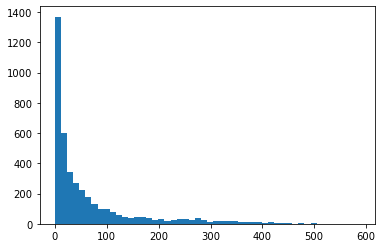

In [193]:
n, bins, _ = plt.hist(df_commented_vids.msg_per_min,bins=50)
plt.show()

In [194]:
list(zip(n[:5],bins[:5]))

[(1370.0, 0.0037859666834931843),
 (599.0, 11.74135408296626),
 (344.0, 23.47892219924903),
 (270.0, 35.2164903155318),
 (222.0, 46.954058431814566)]

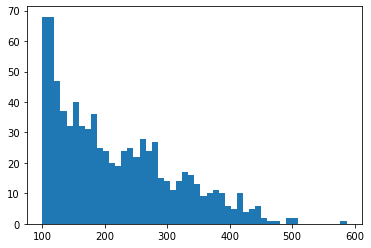

In [195]:
n, bins, _ = plt.hist(df_commented_vids.msg_per_min,bins=50, range=(100,df_commented_vids.msg_per_min.max()))
plt.show()

messages per minute helps us to characterize the VODs:

In [196]:
sum(n)

814.0

In [197]:
len(set(df_vid_info.title))

4035

In [198]:
df_vid_info.title.count()

5953

## Duplicates
There are no duplicated videos, however there are duplicated titles. This seems to stem from:

a) some titles being " " one whitespace only

b) some streams being stopped and restarted with the same title

In [199]:
df_vid_info[df_vid_info.duplicated()].title.count()

0

In [200]:
print(f"{df_vid_info.title.duplicated().sum()} duplicated titles")

1918 duplicated titles


In [201]:
set(df_vid_info[df_vid_info.title.duplicated()].title)

{' ',
 '   TLC Spring 2015 Singapore - W1D1 - RJB vs Exgs',
 '   TLC Spring 2015 Singapore - W1D2 - NYZ vs GR',
 '  LPL Summer: IM vs. LGD | OMG vs. WE | VG vs. RNG',
 ' GRF vs. JAG - AF vs. HLE | Week 10 Day 2 | LCK Summer Split (2019)',
 ' S04 vs RB Game 1 - EU CS 2017 Summer Season - Week 1',
 '(REBROADCAST) 2016 All-Star Event: Day 3',
 '(REBROADCAST) Academy Rush Week 3',
 '(REBROADCAST) EU LCS Spring: Week 1 Day 1',
 '(REBROADCAST) EU LCS Summer Split (2018) | Week 5 Day 1',
 '(REBROADCAST) EU LCS Summer: Week 6 Day 2',
 '(REBROADCAST) FNC vs. G2 | Final | EU LCS Spring | Fnatic vs. G2 Esports (2018)',
 '(REBROADCAST) MSI Play-In Knockout: EVOS Esports vs. BAUSuperMassive eSports',
 '(REBROADCAST) MSI Play-In Knockout: Flash Wolves vs. Gambit Esports',
 '(REBROADCAST) RNG v FNC | Semifinals | Mid-Season Invitational (2018)',
 '(REBROADCAST) RNG vs. EDG | Final | LPL Spring | Royal Never Give Up vs. Edward Gaming (2018)',
 '(REBROADCAST) Rift Rivals NA x EU: Day 1',
 '(REBROADCAST

In [38]:
df_vid_info[df_vid_info.title.duplicated()].sort_values("title")

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,duration_hrs,msg_per_min
id,,,,,,,,,
1155878474,,2021-09-22 10:55:28+00:00,29528,False,1h56m22s,101032,437020,1.939444,253.749642
448475597,,2019-07-05 06:24:35+00:00,13650,False,6h38m55s,61046,258773,6.648611,34.217673
1013003051,,2021-05-06 11:38:35+00:00,0,False,7h46m12s,0,0,7.770000,0.000000
1013003053,,2021-05-06 11:38:35+00:00,151294,False,7h46m12s,508195,2365022,7.770000,324.525955
1155878473,,2021-09-22 10:55:28+00:00,0,False,1h56m22s,0,0,1.939444,0.000000
...,...,...,...,...,...,...,...,...,...
1115898498,🔴 LIVE - ESL Mobile Open presents Wild Rift Oc...,2021-08-12 09:42:37+00:00,304,False,5h36m13s,1688,6804,5.603611,0.904179
164773191,🔴 LIVE: Return of the Legends - Team NA vs Te...,2017-08-06 01:50:57+00:00,8150,False,3h1m20s,28434,140569,3.022222,44.944853
160383776,🔴 [LIVE] ESL Premiership - 2017 Autumn Group S...,2017-07-19 17:48:04+00:00,1,False,4m48s,4,11,0.080000,0.208333


In [39]:
df_vid_info[df_vid_info.title == " "]

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,duration_hrs,msg_per_min
id,,,,,,,,,
368573688,,2019-01-23 17:52:34+00:00,54,False,4m25s,120,478,0.073611,12.226415
448475597,,2019-07-05 06:24:35+00:00,13650,False,6h38m55s,61046,258773,6.648611,34.217673
979788223,,2021-04-08 11:45:45+00:00,14460,False,5h9m25s,74225,435192,5.156944,46.733100
1013003051,,2021-05-06 11:38:35+00:00,0,False,7h46m12s,0,0,7.770000,0.000000
1013003053,,2021-05-06 11:38:35+00:00,151294,False,7h46m12s,508195,2365022,7.770000,324.525955
1155878473,,2021-09-22 10:55:28+00:00,0,False,1h56m22s,0,0,1.939444,0.000000
1155878474,,2021-09-22 10:55:28+00:00,29528,False,1h56m22s,101032,437020,1.939444,253.749642


In [40]:
df_vid_info[df_vid_info.title.duplicated()].sort_values("title").iloc[0].title

' '

some streams actually have no title https://www.twitch.tv/videos/1013003053

## Filtering out videos to reduce the number of messages

Discard videos without messages

In [202]:
df_reduced = df_vid_info[df_vid_info.msg_count > 0]
f"{df_commented_vids.title.count()}/{df_vid_info.title.count()} videos with comments"

'4072/5953 videos with comments'

discard reruns

In [203]:
# to look at stream titles, write them to file
# with open("stream_titles.txt", "w") as out_file:
#    out_file.write("\n".join(sorted(df_commented_vids.title.unique().tolist())))

In [204]:
df_reduced = df_reduced[df_reduced.is_rerun==False]

In [205]:
df_reduced = df_reduced[df_reduced["duration_hrs"] >= 1] # at least one hour long so you can theoretically find at least one match in the stream

In [206]:
# df_reduced = df_reduced[df_reduced["msg_per_min"] >= 300]

In [207]:
df_reduced.title.count(),df_reduced.msg_count.sum()

(3110, 89960287)

In [208]:
df_reduced.sort_values("duration_hrs", ascending=False)

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,user_login,user_name,view_count,language,type,duration_hrs,msg_per_min
id,,,,,,,,,,,,,,
64357081,Go4LoL EUNE March Monthly Finals,2016-05-03 18:54:34+00:00,455,False,47h56m50s,2105,8167,esl_lol,ESL_LOL,230,en,archive,47.947222,0.158160
205274154,LIVE: League of Legends - ESL AU&NZ Championsh...,2017-11-29 16:04:14+00:00,592,False,47h55m6s,2534,9745,esl_lol,ESL_LOL,132,en,archive,47.918333,0.205906
210250561,[LIVE] ESL Italia Championship 2017 - Winter F...,2017-12-17 07:22:11+00:00,92,False,47h54m59s,297,1173,esl_lol,ESL_LOL,79,en,archive,47.916389,0.032000
97690975,PrimeTime League: Worlds 2016 Finals,2016-10-29 00:02:30+00:00,409973,False,30h17m18s,1222847,5873953,riotgames,Riot Games,228789,en,archive,30.288333,225.594563
330500338,Worlds 24-Hour Countdown to Finals,2018-11-02 06:30:25+00:00,275853,False,28h37m1s,1219072,5746913,riotgames,Riot Games,128909,en,archive,28.616944,160.658312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276815868,NA LCS Lounge: 100 Thieves vs. FlyQuest,2018-06-23 23:51:19+00:00,2153,False,1h0m25s,8346,36709,riotgames2,RiotGames2,1086,en,archive,1.006944,35.635862
865795081,Season 2021 Opening Day | Full Livestream - Le...,2021-01-08 14:52:14+00:00,30185,False,1h0m21s,93860,605057,riotgames,Riot Games,476137,en,archive,1.005833,500.165700
53791149,EU LCS Spring - Week 8 Day 2,2016-03-11 19:02:58+00:00,9943,False,1h0m16s,36620,170128,riotgames,Riot Games,10664,en,archive,1.004444,164.983407


In [209]:
df_reduced.describe()

,msg_count,num_tokens,num_chars,view_count,duration_hrs,msg_per_min
count,3110.000000,3.110000e+03,3.110000e+03,3.110000e+03,3110.000000,3110.000000
mean,28926.137299,1.246472e+05,5.584265e+05,1.498738e+05,5.653771,77.523826
std,42156.780246,2.176550e+05,9.817423e+05,4.763427e+05,2.452952,95.888021
min,1.000000,2.000000e+00,3.000000e+00,1.000000e+01,1.000000,0.003786
25%,3331.500000,1.651825e+04,7.151350e+04,2.768250e+03,4.572569,12.178581
50%,12061.000000,5.186750e+04,2.273465e+05,1.074100e+04,5.769583,40.521668
75%,35063.000000,1.294038e+05,5.760515e+05,5.790575e+04,6.767986,100.709527
max,409973.000000,2.459735e+06,1.467572e+07,7.282586e+06,47.947222,507.795565


In [210]:
df_reduced.msg_count.sum()

89960287

In [211]:
df_reduced.num_tokens.sum()

387652810

In [212]:
df_reduced.index.to_frame().to_csv("../data/videos_chat/filtered_corpus_vids.csv")

In [213]:
df_reduced.duration_hrs.sum()

17583.22861111111

In [240]:
df_reduced.columns

Index(['title', 'created_at', 'msg_count', 'is_rerun', 'duration',
       'num_tokens', 'num_chars', 'user_login', 'user_name', 'view_count',
       'language', 'type', 'duration_hrs', 'msg_per_min'],
      dtype='object')

In [230]:
df_reduced.groupby("user_login")["duration_hrs", "num_tokens"].sum()

/tmp/ipykernel_8343/3061713921.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_reduced.groupby("user_login")["duration_hrs", "num_tokens"].sum()


,duration_hrs,num_tokens
user_login,,
esl_lol,1099.758056,6161197
garenaesports,230.575000,212788
lck,3736.393333,73976218
lec,1418.902778,38622964
lolpacific,60.382500,22426
lpl,4155.282778,29826349
riotgames,6078.729722,231541045
riotgames2,471.479722,3087150
riotlan,331.724722,4202673


In [305]:
df_before_after = pd.concat([df_vid_info.groupby("user_name")["duration_hrs"].count(), df_reduced.groupby("user_name")["duration_hrs"].count()], axis=1)

In [306]:
df_before_after.columns = ["video count raw", "video count filtered"]

In [307]:
df_before_after["user name"] = df_before_after.index

In [308]:
df_before_after

,video count raw,video count filtered,user name
user_name,,,
ESL_LOL,1020,193,ESL_LOL
GarenaEsports,346,48,GarenaEsports
LCK,664,647,LCK
LEC,256,241,LEC
LPL,913,733,LPL
Riot Games,2361,1058,Riot Games
RiotGames2,291,103,RiotGames2
RiotLAN,90,76,RiotLAN
lolpacific,12,11,lolpacific


In [309]:
df_before_after = df_before_after[["user name", "video count raw", "video count filtered"]]

In [310]:
df_before_after

,user name,video count raw,video count filtered
user_name,,,
ESL_LOL,ESL_LOL,1020,193
GarenaEsports,GarenaEsports,346,48
LCK,LCK,664,647
LEC,LEC,256,241
LPL,LPL,913,733
Riot Games,Riot Games,2361,1058
RiotGames2,RiotGames2,291,103
RiotLAN,RiotLAN,90,76
lolpacific,lolpacific,12,11


In [311]:
df_before_after = df_before_after.append(df_before_after.sum(numeric_only=True), ignore_index=True).copy()

In [316]:
df_before_after.loc[9, "user name"] = "total"

In [317]:
df_before_after["video count raw"] = df_before_after["video count raw"].astype(int)
df_before_after["video count filtered"] = df_before_after["video count filtered"].astype(int)

In [322]:
df_before_after = df_before_after.set_index("user name")

In [323]:
df_before_after.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &  video count raw &  video count filtered \\\\\nuser name     &                  &                       \\\\\n\\midrule\nESL\\_LOL       &             1020 &                   193 \\\\\nGarenaEsports &              346 &                    48 \\\\\nLCK           &              664 &                   647 \\\\\nLEC           &              256 &                   241 \\\\\nLPL           &              913 &                   733 \\\\\nRiot Games    &             2361 &                  1058 \\\\\nRiotGames2    &              291 &                   103 \\\\\nRiotLAN       &               90 &                    76 \\\\\nlolpacific    &               12 &                    11 \\\\\ntotal         &             5953 &                  3110 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [244]:
df_vid_info.groupby("user_login")["duration_hrs", "num_tokens", "num_chars"].sum()

/tmp/ipykernel_8343/2203095478.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_vid_info.groupby("user_login")["duration_hrs", "num_tokens", "num_chars"].sum()


,duration_hrs,num_tokens,num_chars
user_login,,,
esl_lol,13467.323611,8049324,34885710
garenaesports,864.498056,213371,853969
lck,3751.632222,74047523,330465564
lec,1425.793611,38651113,178038158
lolpacific,60.776389,22431,94075
lpl,4198.329722,30158991,130617540
riotgames,12346.129722,246404111,1103546442
riotgames2,1419.328889,3219292,14037549
riotlan,334.290000,4220314,18494619


In [326]:
set(df_reduced.language)

{'en'}

## Interesting observations

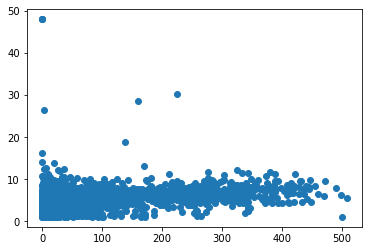

In [52]:
plt.scatter(df_reduced.msg_per_min, df_reduced.duration_hrs)
plt.show()

In [53]:
pearsonr(df_reduced.msg_per_min, df_reduced.duration_hrs)

(0.18627881340871996, 1.114463546358351e-25)

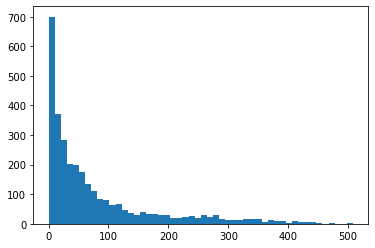

In [328]:
plt.hist(df_reduced.msg_per_min, bins=50)
plt.show()

## Distribution of message densities in matches of Fu et. al dataset

In [85]:
chd = ChatHighlightData(chat_dir="../data/final_data", highlight_dir="../data/gt",)
chd.load_data(file_identifier="nalcs*")

In [86]:
data_totals = chd.get_data_totals()

In [87]:
data_totals["chat_message_count"]/(data_totals["video_length_secs"]/60)

174.60866602711147

characteristics of message counts per video where one __video__ is one __match__ in the tournament

In [88]:
msg_counts =  list()
video_lengths = list()
for match, data in chd.chat.items():
    msg_counts.append(len(utils.unpack_messages(data)))
    video_lengths.append(len(data))

In [89]:
np.std(msg_counts)

5364.576250815363

In [90]:
video_lens_mins = np.asarray(video_lengths)/30/60

In [91]:
video_msg_per_min = np.asarray(msg_counts)/video_lens_mins

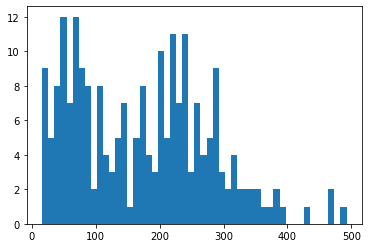

In [92]:
plt.hist(video_msg_per_min,bins=50)
plt.show()

We see two different distributions, inverse to what Bulygin et. al found out about topics. => probably playoffs and finals

[1]D. Bulygin, I. Musabirov, A. Suvorova, K. Konstantinova, and P. Okopnyi, “Between an Arena and a Sports Bar: Online Chats of eSports Spectators,” arXiv:1801.02862 [cs], Dec. 2020, Accessed: Mar. 02, 2022. [Online]. Available: http://arxiv.org/abs/1801.02862

## Selecting VODs based on distributions in our highlight data

We can model the distributions of different features of the videos in our data and then sample VODs based on these criteria until we have a certain amount of tokens

Follow this guide to get the bi-modal distribution out: https://machinelearningmastery.com/probability-density-estimation/

In [93]:
def model_from_samples(s, b):
    # fit density
    sample = s.reshape((-1, 1))
    m = KernelDensity(bandwidth=b, kernel='gaussian')
    return m.fit(s)

In [94]:
def plot_model(v, model):
    # sample probabilities for a range of outcomes
    values = np.arange(0,v.max(),1)
    values = values.reshape((-1, 1))
    probabilities = m.score_samples(values)
    probabilities = np.exp(probabilities)
    
    # plot the histogram and pdf
    plt.hist(v, bins=50, density=True)
    plt.plot(values[:], probabilities)
    plt.show()

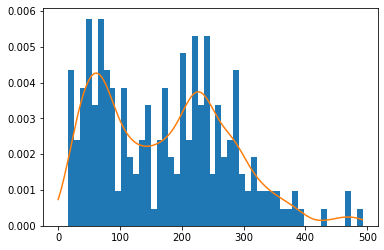

In [95]:
vals = video_msg_per_min.reshape((-1,1))
m = model_from_samples(vals, 20)
plot_model(vals, m)

In [96]:
df_sampled_vids = pd.DataFrame(columns=df_reduced.columns)

while df_sampled_vids.num_tokens.sum() < 5*10**7:
    val = m.sample()[0,0]
    idx = df_reduced.msg_per_min.apply(lambda x: abs(x-val)).idxmin()
    df_sampled_vids = pd.concat([df_sampled_vids, df_reduced[df_reduced.index == idx]])

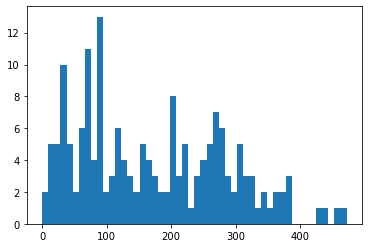

In [97]:
plt.hist(df_sampled_vids.msg_per_min,bins=50)
plt.show()

In [98]:
df_sampled_vids.msg_count.sum(), df_sampled_vids.num_tokens.sum()

(11491772, 50329081)

In [99]:
list(df_sampled_vids.title)

['LCK Playoffs: SK telecom T1 vs. Afreeca Freecs',
 'DK vs GENㅣ2021 LCK Spring Split Finals',
 'DYN vs. GEN - SB vs. kt [2020 LCK Summer Split]',
 'Week 3 Day 2 | LEC Summer Split (2019)',
 'Week 9 Day 2 | LEC Summer Split (2019)',
 'Week 9 Day 2 | LEC Spring Split (2019): Fnatic vs. Splyce',
 '[ES] Campeonato Mundial 2016: Cuartos de Final 1 Samsung Galaxy vs. Cloud9',
 'DK vs KT | NS vs T1 | 2022 LCK Spring Split',
 'EU LCS Summer: Fnatic vs. Splyce | Origen vs. Giants | S04 vs. ROC (EULCS1)',
 'SKT vs. GRF - KT vs. GEN | Week 7 Day 2 | LCK Spring Split (2019)',
 'DK vs AF - T1 vs KTㅣ2021 LCK Spring Split',
 '2016 Mid-Season Invitational: Semifinals Day 2',
 'T1 vs. AF | Round 2 [2020 LCK Regional Qualifier]',
 '2017 All-Star Event: Day 4',
 'LCK Summer: KZ vs. GEN - AFS vs. SKT - KT vs. JAG',
 'LCK Spring: MVP vs. JAG - KT vs. KSV',
 'T1 vs. DRX I Playoffs Round 2 [2020 LCK Spring Split]',
 'IWC All-Star Event: Day 2',
 'Worlds 2018: Group Stage Day 2',
 'KT vs. GRF - SKT vs. GEN | 

### Look at the tokens

In [3]:
with open("../data/video_info/chat_tok_frequencies.json", "r") as in_file:
    tok_freqs = json.load(in_file)

In [4]:
toks = Counter(tok_freqs)

In [5]:
toks.most_common(100)

[('lul', 15522593),
 ('?', 12845502),
 ('na', 6539201),
 ('kekw', 5473178),
 ('eu', 4943149),
 ('pogchamp', 4728134),
 ('is', 4162838),
 ('the', 3862338),
 ('to', 3153405),
 ('!', 3030817),
 ('residentsleeper', 3007543),
 (',', 2795208),
 ('this', 2657500),
 ('pog', 2548174),
 ('4head', 2324588),
 ('i', 2320458),
 ('a', 2314005),
 ('.', 2308695),
 ('morphintime', 2072969),
 ('in', 1990263),
 ('kreygasm', 1952040),
 ('<3', 1927902),
 ('so', 1897339),
 ('poggers', 1825149),
 ('no', 1789797),
 ('peped', 1750975),
 ('and', 1710590),
 ('kappa', 1634301),
 ('gg', 1632641),
 ('you', 1618305),
 ('tsm', 1576826),
 ('go', 1570839),
 ('catjam', 1486010),
 ('omegalul', 1479080),
 ('>', 1433945),
 ('trihard', 1381991),
 ('wutface', 1374000),
 ('chat', 1358446),
 ('elegiggle', 1353204),
 ('for', 1348070),
 ('of', 1314357),
 ('biblethump', 1310777),
 ('lulw', 1246870),
 ('1', 1227875),
 ('"', 1215049),
 ('monkas', 1195787),
 ('g2', 1164349),
 ('clap', 1147922),
 ('faker', 1144207),
 ('my', 1118592),


In [12]:
twitch_emotes = None
with open("../data/emotes/twitch_emotes.txt", "r") as in_file:
    twitch_emotes = [l.strip("\n") for l in in_file.readlines()]

In [25]:
twitch_emotes_meta = None
with open("../data/emotes/twitch_emotes.json", "r") as in_file:
    twitch_emotes_meta = json.load(in_file)["data"]

In [28]:
df_tem = pd.DataFrame.from_records(twitch_emotes_meta)

In [69]:
df_tem

,id,name,images,format,scale,theme_mode
0,emotesv2_031bf329c21040a897d55ef471da3dd3,Jebasted,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]"
1,emotesv2_30050f4353aa4322b25b6b044703e5d1,PogBones,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]"
2,emotesv2_4c39207000564711868f3196cc0a8748,PoroSad,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]"
3,emotesv2_7c5d25facc384c47963d25a5057a0b40,KEKHeim,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]"
4,emotesv2_4acac638cffb4db49f376059f7077dae,CaitlynS,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]"
...,...,...,...,...,...,...
279,5,:|,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]"
280,4,>(,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]"
281,3,:D,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]"
282,2,:(,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]"


In [70]:
twitch_emotes_lower = {te.lower(): te for te in twitch_emotes}

In [71]:
toks_twitch_emotes = Counter({twitch_emotes_lower[t]:c for t,c in toks.items() if t in twitch_emotes_lower.keys()})

In [72]:
toks_twitch_emotes.most_common(10)

[('LUL', 15522593),
 ('PogChamp', 4728134),
 ('ResidentSleeper', 3007543),
 ('4Head', 2324588),
 ('MorphinTime', 2072969),
 ('Kreygasm', 1952040),
 ('<3', 1927902),
 ('Kappa', 1634301),
 ('TriHard', 1381991),
 ('WutFace', 1374000)]

In [73]:
df_toks_tem = pd.DataFrame.from_records([{"name": n, "count": c} for n, c in toks_twitch_emotes.items()])

In [74]:
df_toks_tem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    239 non-null    object
 1   count   239 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ KB


In [75]:
df_tem_cnts = pd.merge(df_tem, df_toks_tem, how="inner", on=["name"]).dropna()

In [77]:
df_tem_cnts.sort_values(["count"], ascending=False).head(11)

,id,name,images,format,scale,theme_mode,count
92,425618,LUL,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",15522593
21,305954156,PogChamp,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",4728134
215,245,ResidentSleeper,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",3007543
214,354,4Head,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",2324588
109,156787,MorphinTime,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",2072969
229,41,Kreygasm,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",1952040
45,9,<3,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",1927902
44,555555584,<3,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",1927902
238,25,Kappa,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",1634301
121,120232,TriHard,{'url_1x': 'https://static-cdn.jtvnw.net/emoti...,[static],"[1.0, 2.0, 3.0]","[light, dark]",1381991


In [87]:
tem_cnts = df_tem_cnts[["images", "name", "count"]].sort_values(["count"], ascending=False).head(10).to_dict()

In [104]:
df_tem_cnts[["name", "count"]].sort_values(["count"], ascending=False).head(10).to_latex()

'\\begin{tabular}{llr}\n\\toprule\n{} &             name &     count \\\\\n\\midrule\n92  &              LUL &  15522593 \\\\\n21  &         PogChamp &   4728134 \\\\\n215 &  ResidentSleeper &   3007543 \\\\\n214 &            4Head &   2324588 \\\\\n109 &      MorphinTime &   2072969 \\\\\n229 &         Kreygasm &   1952040 \\\\\n45  &               <3 &   1927902 \\\\\n44  &               <3 &   1927902 \\\\\n238 &            Kappa &   1634301 \\\\\n121 &          TriHard &   1381991 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df_tem_cnts.to_latex

In [88]:
tem_cnts.keys()

dict_keys(['images', 'name', 'count'])

In [103]:
for (indx, img), (indx2, name) in zip(tem_cnts["images"].items(), tem_cnts["name"].items()):
    assert(indx == indx2)
    print(indx, img["url_4x"], indx2, name)
    response = requests.get(img["url_4x"])
    if response.status_code == 200:
        with open(f"../data/emotes/emotes_images/{name}.png", 'wb') as f:
            f.write(response.content)


92 https://static-cdn.jtvnw.net/emoticons/v2/425618/static/light/3.0 92 LUL
21 https://static-cdn.jtvnw.net/emoticons/v2/305954156/static/light/3.0 21 PogChamp
215 https://static-cdn.jtvnw.net/emoticons/v2/245/static/light/3.0 215 ResidentSleeper
214 https://static-cdn.jtvnw.net/emoticons/v2/354/static/light/3.0 214 4Head
109 https://static-cdn.jtvnw.net/emoticons/v2/156787/static/light/3.0 109 MorphinTime
229 https://static-cdn.jtvnw.net/emoticons/v2/41/static/light/3.0 229 Kreygasm
45 https://static-cdn.jtvnw.net/emoticons/v2/9/static/light/3.0 45 <3
44 https://static-cdn.jtvnw.net/emoticons/v2/555555584/static/light/3.0 44 <3
238 https://static-cdn.jtvnw.net/emoticons/v2/25/static/light/3.0 238 Kappa
121 https://static-cdn.jtvnw.net/emoticons/v2/120232/static/light/3.0 121 TriHard


## Twitch LoL corpus analysis

In [3]:
chat_files = glob.glob("../data/videos_chat/corpus/[0-9]*[0-9].txt")

In [4]:
len(chat_files)

3110

In [9]:
token_counts = list()
tok = TweetTokenizer()
for cf in chat_files:
    with open(cf, "r") as in_file:
        token_counts.extend([len(tok.tokenize(l.strip("\n"))) for l in in_file.readlines()])

In [5]:
corpus = list()

In [12]:
token_counts = [tc for tc in token_counts if tc > 0]

In [13]:
np.max(token_counts), np.min(token_counts), np.mean(token_counts)

(487, 1, 4.266766532291709)

In [19]:
for cf in chat_files:
    with open(cf, "r") as in_file:
        corpus.extend([l.strip("\n") for l in in_file.readlines()])

In [27]:
len(corpus)

88976902

In [10]:
msg_lens = [len(m.split()) for m in corpus]

In [29]:
del corpus

In [12]:
np.max(msg_lens)

160

In [13]:
np.argmax(msg_lens)

5785957

In [14]:
lens_inds = list(zip(msg_lens, list(range(len(msg_lens)))))

In [15]:
lens_inds = sorted(lens_inds, key=lambda x: x[0], reverse=True)

In [16]:
lens_inds[-50:]

[(1, 88976727),
 (1, 88976730),
 (1, 88976731),
 (1, 88976735),
 (1, 88976736),
 (1, 88976739),
 (1, 88976740),
 (1, 88976749),
 (1, 88976750),
 (1, 88976757),
 (1, 88976759),
 (1, 88976761),
 (1, 88976762),
 (1, 88976763),
 (1, 88976764),
 (1, 88976767),
 (1, 88976776),
 (1, 88976777),
 (1, 88976782),
 (1, 88976789),
 (1, 88976792),
 (1, 88976793),
 (1, 88976800),
 (1, 88976805),
 (1, 88976813),
 (1, 88976823),
 (1, 88976824),
 (1, 88976827),
 (1, 88976831),
 (1, 88976832),
 (1, 88976841),
 (1, 88976842),
 (1, 88976846),
 (1, 88976848),
 (1, 88976851),
 (1, 88976852),
 (1, 88976853),
 (1, 88976855),
 (1, 88976856),
 (1, 88976857),
 (1, 88976861),
 (1, 88976868),
 (1, 88976890),
 (1, 88976893),
 (1, 88976899),
 (1, 88976901),
 (0, 7592313),
 (0, 17146755),
 (0, 53287600),
 (0, 55891633)]

In [17]:
del lens_inds

In [22]:
lens_inds_50 = [(160, 5785957),
 (159, 5785993),
 (130, 25614125),
 (130, 65890428),
 (130, 65890453),
 (130, 65890461),
 (130, 65890470),
 (130, 65890476),
 (130, 65890483),
 (128, 45969225),
 (128, 64789105),
 (128, 64789171),
 (127, 16075923),
 (126, 37188753),
 (125, 65890639),
 (125, 71741998),
 (124, 5791610),
 (124, 21460579),
 (124, 21460915),
 (124, 65890902),
 (124, 65890909),
 (123, 65890895),
 (123, 87788107),
 (122, 65890852),
 (122, 65890886),
 (122, 65891119),
 (122, 71741992),
 (121, 65890876),
 (121, 71741952),
 (121, 71741973),
 (121, 87762987),
 (121, 87764537),
 (121, 87786183),
 (120, 9920030),
 (120, 19827673),
 (120, 32259522),
 (120, 48794617),
 (120, 56165034),
 (120, 65890482),
 (120, 65890492),
 (120, 65890624),
 (120, 65890630),
 (120, 65890631),
 (120, 65890642),
 (120, 65890666),
 (120, 65890824),
 (120, 65890834),
 (120, 65890842),
 (120, 65890853),
 (120, 65890866)]

In [23]:
lens_inds_last50 = [(1, 88976727),
 (1, 88976730),
 (1, 88976731),
 (1, 88976735),
 (1, 88976736),
 (1, 88976739),
 (1, 88976740),
 (1, 88976749),
 (1, 88976750),
 (1, 88976757),
 (1, 88976759),
 (1, 88976761),
 (1, 88976762),
 (1, 88976763),
 (1, 88976764),
 (1, 88976767),
 (1, 88976776),
 (1, 88976777),
 (1, 88976782),
 (1, 88976789),
 (1, 88976792),
 (1, 88976793),
 (1, 88976800),
 (1, 88976805),
 (1, 88976813),
 (1, 88976823),
 (1, 88976824),
 (1, 88976827),
 (1, 88976831),
 (1, 88976832),
 (1, 88976841),
 (1, 88976842),
 (1, 88976846),
 (1, 88976848),
 (1, 88976851),
 (1, 88976852),
 (1, 88976853),
 (1, 88976855),
 (1, 88976856),
 (1, 88976857),
 (1, 88976861),
 (1, 88976868),
 (1, 88976890),
 (1, 88976893),
 (1, 88976899),
 (1, 88976901),
 (0, 7592313),
 (0, 17146755),
 (0, 53287600),
 (0, 55891633)]

In [24]:
for l, i in lens_inds_50:
    print(l, corpus[i],"\n")

160 <3 A R G E N T I N A <3 GO <3 A R G E N T I N A <3 GO <3 A R G E N T I NA <3 LUL A R G E N T I N A LUL A R G E N T I NA LUL<3 A R G E N T I N A <3 GO <3 A R G E N T I N A <3 GO <3 A R G E N T I NA <3 LUL A R G E N T I N A LUL A R G E N T I NA LUL<3 A R G E N T I N A <3 GO <3 A R G E N T I N A <3 GO <3 A R G E N T I NA <3 LUL A R G E N T I N A LUL A R G E N T I NA LUL 

159 <3 A R G E N T I N A <3 GO <3 A R G E N T I N A <3 GO <3 A R G E N T I NA <3 LUL A R G E N T I N A LUL A R G E N T I NA LUL<3 A R G E N T I N A <3 GO <3 A R G E N T I N A <3 GO <3 A R G E N T I NA <3 LUL A R G E N T I N A LUL A R G E N T I NA LUL<3 A R G E N T I N A <3 GO <3 A R G E N T I N A <3 GO <3 A R G E N T I NA <3 LUL A R G E N T I N A LUL A R G E N T I NA 

130 S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N F O N S O N S U A N 

In [26]:
for l, i in lens_inds_last50:
    print(l, corpus[i],"\n")

1 GMB!GMB!GMB! 

1 PENTAKILL 

1 FF 

1 LUL 

1 LUL 

1 LOL 

1 lol 

1 xD 

1 Pff.....Vodcast 

1 LUL 

1 KappaPride 

1 BlessRNG 

1 FeelsBadMan 

1 XD 

1 gg 

1 VoHiYo 

1 DansGame 

1 no! 

1 MEDIC 

1 Yeahhhhh 

1 Yeahhhhhhggg 

1 na<ociana 

1 ty 

1 PogChamp 

1 LUL 

1 04:20 

1 4:20 

1 V/\ 

1 blaze 

1 3:20!!!!!!!!!!! 

1 lul 

1 XD 

1 4Head 

1 CiGrip 

1 KONTENT 

1 Rebroadcast 

1 nope 

1 Yea 

1 ANELE 

1 hot 

1 kipiChamp 

1 unbelievable 

1 monkaS 

1 EU* 

1 song? 

1 TriHard 

0  

0  

0  

0  

